# NAVARCH 565 FA 24 Homework 3

### File Submission Instructions

#### Submit 3 Files:
- `Problem1.py`
- `Problem2.py`
- `YourNet.pth`

Please submit the Python files (`Problem1.py`, `Problem2.py`) along with one trained network file (`YourNet.pth`) that you will generate from Problem 2 (see below). Make sure to name the checkpoint files as **`YourNet.pth`**, as the autograder will look for this specific filename.

Enjoy learning Geometry and Basic Deep Learning!

# Objectives

In this assignment, we will learn to create and train a neural network for image classification. In the task of image classification, we are given an image as input and asked to classify the image within one of a set number of classes. In this case, we will train a network to classify images as one of three labels: car, person, or neither. This information can be especially useful for a self-driving car seeking to identify dynamic objects.

Before we start, take a quick read through the PyTorch tutorial on image classification: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We will be referencing the tutorial throughout, and in the end of the assignment you will get a chance to improve upon the network.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
# %load_ext autoreload
# %autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. If prompted "Permit this notebook to access your Google Drive files?", select "Connect to Google Drive", and sign in to your Google account (the same account you used to store this notebook).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Path configuration
Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['utils.py', 'Problem2.py', 'Data', 'CarOrNot.ipynb']
```

If you are working on a local machine, just set `GOOGLE_DRIVE_PATH` to the path of your `Problem1` folder.

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2024FA folder and put all the files under A3 folder, then '2024FA/A3/Problem2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "student/Problem2"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'utils.py', 'Data', '__pycache__', 'Problem2.py', 'TutorialNet.pth', 'YourNet.pth', 'CarOrNot.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [5]:
# Imports
import numpy as np
import torch
import yaml

%matplotlib inline

Next we will check if a GPU is available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Welcome to assignment 3!
```

In [7]:
from utils import *
from Problem2 import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'Problem2.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('Problem2.py last edited on %s' % py_edit_time)

Welcome to assignment 3!
Problem2.py last edited on Fri Nov  7 20:59:22 2025


# Data Visualization

First, let's take a look at some examples of images from the dataset to get a feel for the data. Navigate to the `Train` folder within the `Data` folder to take a look at some of the example images our network will be tasked with labeling. Notice that the images are all of different sizes, which can be challenging for our network.

### PyTorch Imports and Parameters

We need some imports for PyTorch to run, which are found in the code cell below. We also need to set some hyper-parameters. Don't worry about these for now, later you will get a chance to tune them.



*   `batch_size` is the number of data examples within a mini-batch.
*   `lr` is the learning rate of the network.
*   `num_epochs` is the number of epochs, or times the network will train on each individual example.





In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
batch_size = 4
lr = 0.0003
num_epochs = 10

### Data Loader
Next, we will create data loaders for the training and validation set. Take a look in your Python file at the class `Cars` to how PyTorch datasets are created. Later in your final project you will need to create your own data loaders.

Remember how the images were all of different sizes? Fortunately, PyTorch includes special data transformation functions for us to transform each image to the same size. Check out the `transform_train()` function to see how this is accomplished.

In [10]:
trainset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Train"),
                transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=trainset.collate_fn)

valset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Val"),
                transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=valset.collate_fn)

classes = ('None', 'Car', 'Person')

Now that we have a data loader, we can take a look at some of the transformed images. Since the PyTorch classification tutorial is on 32x32 pixel images, we will stick with the same. Unfortunately, at that resolution it is difficult to distinguish objects in some of the images. Later, you will get a chance to modify the transformation pipeline and network to operate on your choice of image resolutions.

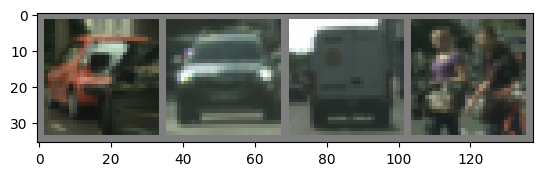

Car   Car   Car   Person


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Hello World
Now is your chance to create your first network! Read through the PyTorch image classification documentation and implement the demo network in class `TutorialNet`. Note that you will need to make a modification to the network, changing the output size of the last layer to 3 in order to match the number of classes in our dataset.

To train our network, we will use the Cross Entropy Loss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [12]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
net = TutorialNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

Now that the network is created, we can try to run it! Note that you do not need GPU for this assignment, and CPU will be sufficient.

The training function is structured as a loop over the number of epochs. Within each epoch, the network first trains over the entire training dataset. Some important steps when training are to:
1.   Zero (reset) the gradient.
2.   Calculate predictions and a loss function from the predictions.
3.   Call `backward()` to calculate the gradient.
4.   Step the optimizer to update the network parameters.

After the training loop, we also iterate over the validation set to understand how well the network is fitting the data. If the network is fitting the training set but not the validation set, this is known as over-fitting and indicates the network may not adapt well to new data.



In [13]:
def train_net(net, trainloader, val_loader, device, num_epochs):
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      # Train
      net.train()
      running_loss = 0.0
      num_iters = 0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          num_iters += labels.shape[0]

      # print statistics
      print(f'epochs: {epoch + 1} loss: {running_loss / num_iters:.3f}')
      running_loss = 0.0
      num_iters = 0

      # Validate
      num_correct = 0
      num_total = 0
      net.eval()
      with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)

            # Check correct
            _, predicted = torch.max(outputs, 1)
            num_correct += torch.sum(predicted == labels)
            num_total += predicted.shape[0]

      # print statistics
      print(f'epochs: {epoch + 1} Accuracy Val: {100 * num_correct / num_total:.3f}')
  print('Finished Training')

In [14]:
train_net(net, trainloader, val_loader, device, num_epochs)

epochs: 1 loss: 0.276
epochs: 1 Accuracy Val: 40.000
epochs: 2 loss: 0.273
epochs: 2 Accuracy Val: 46.000
epochs: 3 loss: 0.271
epochs: 3 Accuracy Val: 48.000
epochs: 4 loss: 0.268
epochs: 4 Accuracy Val: 46.000
epochs: 5 loss: 0.259
epochs: 5 Accuracy Val: 48.000
epochs: 6 loss: 0.255
epochs: 6 Accuracy Val: 50.000
epochs: 7 loss: 0.243
epochs: 7 Accuracy Val: 46.000
epochs: 8 loss: 0.232
epochs: 8 Accuracy Val: 54.000
epochs: 9 loss: 0.220
epochs: 9 Accuracy Val: 54.000
epochs: 10 loss: 0.212
epochs: 10 Accuracy Val: 48.000
Finished Training


### Save Network
Next, we will save the network to the file `TutorialNet.pth` so it can be loaded later for evaluation.

In [15]:
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'TutorialNet.pth')
torch.save(net.state_dict(), PATH)

Let's try evaluating the saved weights on some images from the validation set. Hopefully, your network predictions were similar to the ground truth. Don't worry if several predictions were wrong. Next you will get a chance to improve the training by playing with hyper-parameters, network architecture, and image resolution.

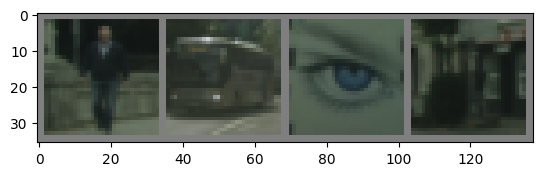

GroundTruth:  Person Car   None  None 
Predicted:  Person Person Person Person


In [16]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Load state dict
net = TutorialNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

# Your Turn!
Now that you have learned the basics, have some fun experimenting! Implement `YourNet()` with whatever layers you want. It could be a copy of the previous network, or you can make improvements. You can also try changing the hyper-parameters such as the learning rate, batch size, or number of epochs which we have copied to the cell below for your convenience. Additionally, you can change the `transform_train()` and `transform_test()` functions to have a different size or data augmentations such as `RandomHorizontalFlip()`.

To evaluate your network, we will load the frozen weights and use your `transform_test()` function to test the classifier on a hidden test set.

In [26]:
batch_size = 10
lr = 0.0003
num_epochs = 30

In [27]:
# Recreate the data loaders in case they have changed
trainset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Train"),
                transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=trainset.collate_fn)

valset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Val"),
                transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=valset.collate_fn)

# Load the network
net = YourNet().to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Train the network
train_net(net, trainloader, val_loader, device, num_epochs)

# Save the weights
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'YourNet.pth')
torch.save(net.state_dict(), PATH)

epochs: 1 loss: 0.058
epochs: 1 Accuracy Val: 38.000
epochs: 2 loss: 0.058
epochs: 2 Accuracy Val: 40.000
epochs: 3 loss: 0.057
epochs: 3 Accuracy Val: 48.000
epochs: 4 loss: 0.057
epochs: 4 Accuracy Val: 44.000
epochs: 5 loss: 0.056
epochs: 5 Accuracy Val: 42.000
epochs: 6 loss: 0.055
epochs: 6 Accuracy Val: 48.000
epochs: 7 loss: 0.055
epochs: 7 Accuracy Val: 48.000
epochs: 8 loss: 0.053
epochs: 8 Accuracy Val: 46.000
epochs: 9 loss: 0.050
epochs: 9 Accuracy Val: 48.000
epochs: 10 loss: 0.047
epochs: 10 Accuracy Val: 48.000
epochs: 11 loss: 0.046
epochs: 11 Accuracy Val: 48.000
epochs: 12 loss: 0.045
epochs: 12 Accuracy Val: 50.000
epochs: 13 loss: 0.044
epochs: 13 Accuracy Val: 58.000
epochs: 14 loss: 0.045
epochs: 14 Accuracy Val: 50.000
epochs: 15 loss: 0.039
epochs: 15 Accuracy Val: 58.000
epochs: 16 loss: 0.037
epochs: 16 Accuracy Val: 62.000
epochs: 17 loss: 0.034
epochs: 17 Accuracy Val: 62.000
epochs: 18 loss: 0.031
epochs: 18 Accuracy Val: 62.000
epochs: 19 loss: 0.031
epoch

Run the following cell to visualize your saved weights

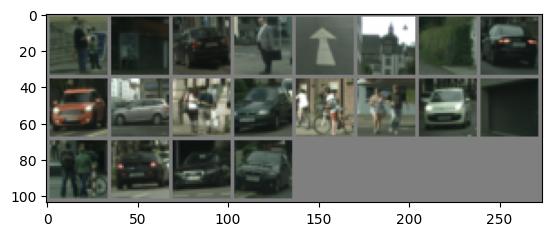

GroundTruth:  Person None  Car   Person None  None  None  Car   Car   Car   Person Car   Person Person Car   None  Person Car   Car   Car  
Predicted:  Person None  Car   Person Person None  None  Car   Car   None  None  Car   Person None  Car   None  Person Car   Person Car  


In [28]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

net = YourNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

# That's it!
When you are happy with your network's performance, submit the weights to the autograder to evaluate on the test set. We will run your network and grade the output on a hidden test set. Make sure the network is not too large, otherwise it may fail to finish running.

This problem contains two grades:
*   50 points for having the correct number of classes in your network final layer
*   150 points from the accuracy on the test set, based on a sliding scale with partial credit.

For submission, please submit `Problem1.py`, `Problem2.py`, and `YourNet.pth`.
